# 图像梯度

## 1.梯度的概念

函数 z = f(x,y)在平面区域D内具有一阶连续偏导数，则对于每一个属于D点P(x,y)，都可定出一个向量：

$$\frac{\partial\,f}{\partial\,x} \vec i + \frac{\partial\,f}{\partial\,y} \vec j$$

这个向量称为函数 z = f(x,y)在点P出的梯度，记为如下：

$$gradf(x,y) = \frac{\partial\,f}{\partial\,x} \vec i + \frac{\partial\,f}{\partial\,y} \vec j$$

## 2.图像梯度的定义

图像函数f(x,y)在点(x,y)的梯度是一个具有大小和方向的矢量，设为Gx 和 Gy 分别表示x方向和y方向的梯度，这个梯度的矢量可以表示为：

$$\nabla f(x,y) = [G_x,G_y]^T = [\frac{\partial\,f}{\partial\,x},\frac{\partial\,f}{\partial\,y}]^T$$

这个矢量的幅度为:

$$mag(\nabla f) = g(x,y) = \sqrt{\frac{\partial^2 f}{\partial\,x^2} + \frac{\partial^2 f}{\partial\,y^2}}$$

方向角为：

$$\phi(x,y) = arctan\left(\frac {\frac{\partial\,f}{\partial\,x}} {\frac{\partial\,f}{\partial\,y}}\right)$$

对于数字图像而言，相当于对二维离散函数求梯度，如下：

$$G(x,y) = dx(i,j) + dy(i,j)$$

$$dx(i,j)  = I(i+1,j) - I(i,j)$$

$$dy(i,j)  = I(i,j+1) - I(i,j)$$

数字图像中，更多的使用差分来近似导数，最简单的梯度近似表达式如下：

$$G_x = f(x,y) - f(x-1,y)$$

$$G_y = f(x,y) - f(x,y-1)$$

梯度的方向是函数f(x,y)变化最快的方向，当图像中存在边缘时，一定有较大的梯度值，相反，当图像中有比较平滑的部分时，灰度值变化较小，则相应的梯度也较小，图像处理中把梯度的模简称为梯度，由图像梯度构成的图像成为梯度图像(we can get the gradient image through computing the gradient of each pixel in the image)

经典的图像梯度算法是考虑图像的每个像素的某个邻域内的灰度变化，利用边缘临近的一阶或二阶导数变化规律，对原始图像中像素某个邻域设置梯度算子，通常我们用小区域模板进行卷积来计算，有Sobel算子、Robinson算子、Laplace算子等。

In [5]:
import numpy as np
import scipy
from scipy.ndimage import filters
%matplotlib inline
import matplotlib.pyplot as plt
import skimage as ski
import skimage.io as skio
import skimage.color as skcolor

In [12]:
src = skio.imread('../datas/f2.jpg')
gray = skcolor.rgb2gray(src)

In [13]:
# Sobel 或 Prewit 梯度
def gradient(image, type=0):
    if type==0:
        Ix = filters.sobel(image, axis=1)
        Iy = filters.sobel(image, axis=0)
        return Ix, Iy
    else:
        Ix = filters.prewitt(image, axis=1)
        Iy = filters.prewitt(image, axis=0)
    return Ix, Iy

In [14]:
ix,iy = gradient(gray)

Text(0.5,1,'Gradient Sobel:Y')

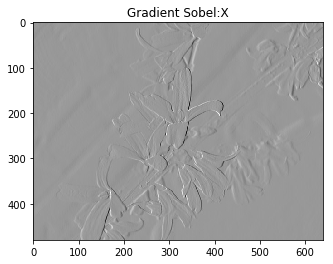

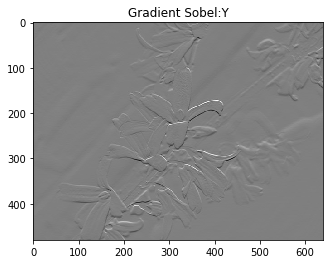

In [20]:
plt.figure()
plt.imshow(ix,'gray')
plt.title('Gradient Sobel:X')
plt.figure()
plt.imshow(iy,'gray')
plt.title('Gradient Sobel:Y')

In [48]:
def gradient2(src):
    dstx = np.zeros_like(src)
    dsty = np.zeros_like(src)
    rows,cols = src.shape[0],src.shape[1]
#     print(dstx[0:rows-1,:].shape,src[0:rows-1,:].shape,src[1:rows,:].shape)
    dstx[0:rows-1,:] = src[0:rows-1,:] - src[1:rows,:]
    dsty[:,0:cols-1] = src[:,0:cols-1] - src[:,1:cols]
    return np.abs(dstx),np.abs(dsty)

In [49]:
dstx,dsty = gradient2(gray)

Text(0.5,1,'Gradient:Y')

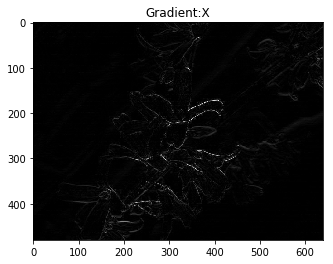

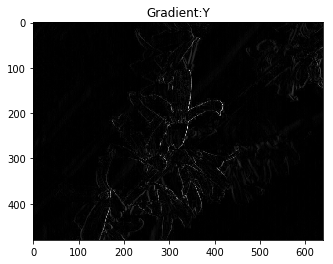

In [51]:
plt.figure()
plt.imshow(dstx,'gray')
plt.title('Gradient:X')
plt.figure()
plt.imshow(dsty,'gray')
plt.title('Gradient:Y')

In [56]:
# gradient magnitudes and directions of a grayscale image, Gd: [-pi/2, +pi/2]
def gray_gradient(image):
    Gx, Gy = gradient(image)
    Gm = np.sqrt(Gx**2+Gy**2)
    Gd = np.arctan2(Gy, Gx)    
    Gd[Gd > 0.5*np.pi] -= np.pi
    Gd[Gd < -0.5*np.pi] += np.pi
    return Gm, Gd

In [57]:
dstx,dsty = gray_gradient(gray)

Text(0.5,1,'Gradient magnitudes:d')

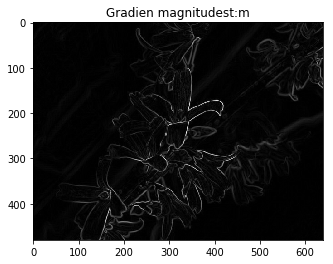

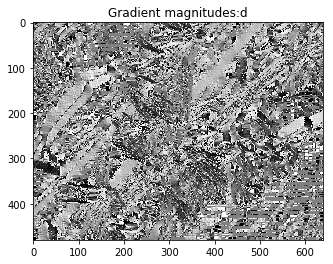

In [59]:
plt.figure()
plt.imshow(dstx,'gray')
plt.title('Gradien magnitudest:m')
plt.figure()
plt.imshow(dsty,'gray')
plt.title('Gradient magnitudes:d')

In [62]:
# using the same approach of color gradient mag-ori computation for a gray image
def gray_gradient_tensor(image, sigma=0.5):
        
    g = image.astype('float32')
    #g = scipy.ndimage.filters.gaussian_filter(g, sigma)
    gx, gy = gradient(g)
    
    cxx = gx*gx
    cyy = gy*gy 
    cxy = 2*(gx*gy)     ## 2*cxy
    
    ## todo: smooth the color tensor
    cxx = filters.gaussian_filter(cxx, sigma)
    cyy = filters.gaussian_filter(cyy, sigma)
    cxy = filters.gaussian_filter(cxy, sigma)
    
    cxx_cyy = cxx-cyy
    eps = 0.0000001
    d = np.sqrt( cxx_cyy**2 + cxy**2 + eps)
    
    ## largest eigenvalue -- derivative energy in the most prominent direction
    lambda1 = cxx + cyy + d          ## 0.5*... ?
    
    Gm = np.sqrt(lambda1 + eps)
    Gd = 0.5*np.arctan2(cxy, cxx_cyy)
    
    return Gm, Gd

In [63]:
dstx,dsty = gray_gradient_tensor(gray)

Text(0.5,1,'Gradient tensor:d')

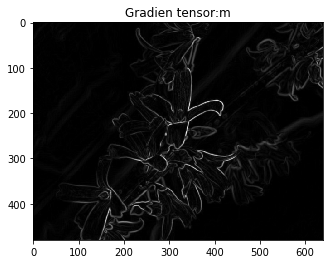

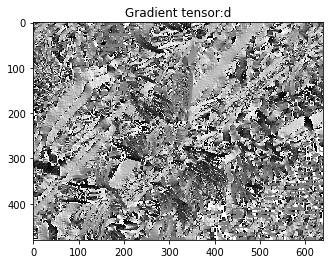

In [64]:
plt.figure()
plt.imshow(dstx,'gray')
plt.title('Gradien tensor:m')
plt.figure()
plt.imshow(dsty,'gray')
plt.title('Gradient tensor:d')

In [65]:
# color gradient from multiple single channel images
# imgs: contains a list of single channel images (pixel values must be in the same range)
# output: Gm, gradient magnitude in the most prominent gradient direction (largest eigenvalue of color tensor)
# Gd: gradient directions [-pi/2, +pi/2]
# Reference: Van De Weijer, Joost and Gevers, Theo and Smeulders, Arnold WM, 'Robust Photometric Invariant Features from the Color Tensor', TIP 2006.
# This Py code was adapted from the Matlab code of the paper
def multi_gradient(imgs, gtype=0, sigma=0.5):
    if gtype==1: return multi_gradient_max(imgs)

    N=len(imgs)    
    # compute gradients
    # first channel    
    gx, gy = gradient(imgs[0])
    # structure tensor (color tensor in RGB images)
    cxx = gx*gx; cyy = gy*gy; cxy = gx*gy
    # remaining channels    
    for i in range(1, N):        
        gx, gy = gradient(imgs[i])
        cxx += gx*gx; cyy += gy*gy; cxy += gx*gy        
    cxy *= 2    ## 2*cxy
    
    ## smooth the structure/color tensor
    cxx = filters.gaussian_filter(cxx, sigma)
    cyy = filters.gaussian_filter(cyy, sigma)
    cxy = filters.gaussian_filter(cxy, sigma)
    
    cxx_cyy = cxx-cyy
    eps = 1e-9
    d = np.sqrt( cxx_cyy**2 + cxy**2 + eps)
        
    ## largest eigenvalue -- derivative energy in the most prominent direction
    lambda1 = cxx + cyy + d          ## 0.5*... ?
        
    Gm = np.sqrt(lambda1 + eps)
    Gd = 0.5*np.arctan2(cxy, cxx_cyy)
    
    return Gm, Gd

# maximum gradient for each pixel in all the channels
def multi_gradient_max(imgs):
    N=len(imgs)      
    Gm,Gd = gray_gradient(imgs[0])
    for i in range(1, N):
        Gm2, Gd2 = gray_gradient(imgs[i])        
        ind= Gm2>Gm
        Gm[ind] = Gm2[ind]       
        Gd[ind] = Gd2[ind]
    return Gm, Gd

# gradient magnitude from an RGB image
# type: 0 (color tensor), else (max)
def rgb_gradient(image, gtype=0, sigma=0.5):
    r = image[:,:,0].astype('float32')
    g = image[:,:,1].astype('float32')
    b = image[:,:,2].astype('float32')
    
    imgs=[]
    imgs.append(r)
    imgs.append(g)
    imgs.append(b)
    
    if gtype == 0:
        return multi_gradient(imgs, sigma)
    else:
        return multi_gradient_max(imgs)

In [70]:
dstx,dsty = rgb_gradient(src)

Text(0.5,1,'Gradient RGB:d')

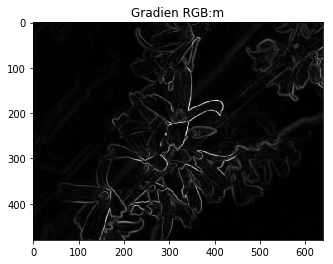

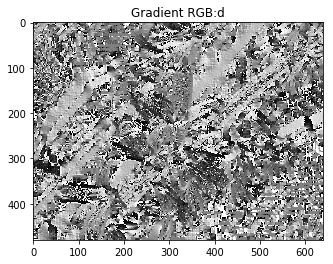

In [71]:
plt.figure()
plt.imshow(dstx,'gray')
plt.title('Gradien RGB:m')
plt.figure()
plt.imshow(dsty,'gray')
plt.title('Gradient RGB:d')